In [1]:
# --- CELDA 0: SETUP ---
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Entorno OK.")


Entorno OK.


In [13]:
import os
os._exit(0)


: 

In [2]:
# --- CELDA 1: CARGA DE DATOS ---
import pandas as pd
df = pd.read_excel(r"C:\Users\Gerson\Documents\dataset-uci.xlsx")
df.shape, df.head()


((319, 39),
    Gallstone Status  Age  Gender  Comorbidity  Coronary Artery Disease (CAD)  \
 0                 0   50       0            0                              0   
 1                 0   47       0            1                              0   
 2                 0   61       0            0                              0   
 3                 0   41       0            0                              0   
 4                 0   42       0            0                              0   
 
    Hypothyroidism  Hyperlipidemia  Diabetes Mellitus (DM)  Height  Weight  \
 0               0               0                       0     185    92.8   
 1               0               0                       0     176    94.5   
 2               0               0                       0     171    91.1   
 3               0               0                       0     168    67.7   
 4               0               0                       0     178    89.6   
 
    ...  High Density Lipoprot

In [9]:
# --- CELDA 2 (ACTUALIZADA): LISTAS DE VARIABLES CON NOMBRES EXACTOS ---
target = "Gallstone Status"

binary_vars = [
    "Coronary Artery Disease (CAD)",
    "Hypothyroidism",
    "Hyperlipidemia",
    "Diabetes Mellitus (DM)"
]

categorical_vars = [
    "Gender",
    "Comorbidity",
    "Hepatic Fat Accumulation (HFA)"
]

continuous_vars = [
    "Age", "Height", "Weight", "Body Mass Index (BMI)",
    "Total Body Water (TBW)", "Extracellular Water (ECW)", "Intracellular Water (ICW)",
    "Extracellular Fluid/Total Body Water (ECF/TBW)",
    "Total Body Fat Ratio (TBFR) (%)", "Lean Mass (LM) (%)", "Body Protein Content (Protein) (%)",
    "Visceral Fat Rating (VFR)", "Bone Mass (BM)", "Muscle Mass (MM)", "Obesity (%)",
    "Total Fat Content (TFC)", "Visceral Fat Area (VFA)", "Visceral Muscle Area (VMA) (Kg)",
    "Glucose", "Total Cholesterol (TC)", "Low Density Lipoprotein (LDL)",
    "High Density Lipoprotein (HDL)", "Triglyceride", "Aspartat Aminotransferaz (AST)",
    "Alanin Aminotransferaz (ALT)", "Alkaline Phosphatase (ALP)", "Creatinine",
    "Glomerular Filtration Rate (GFR)", "C-Reactive Protein (CRP)",
    "Hemoglobin (HGB)", "Vitamin D"
]

# Asegurar que existan (por si alguna columna cambia de nombre)
cols = set(df.columns)
binary_vars      = [c for c in binary_vars if c in cols]
categorical_vars = [c for c in categorical_vars if c in cols]
continuous_vars  = [c for c in continuous_vars if c in cols]

print("Target:", target)
print("Binarias:", len(binary_vars), binary_vars)
print("Categóricas:", len(categorical_vars), categorical_vars)
print("Continuas:", len(continuous_vars))


Target: Gallstone Status
Binarias: 4 ['Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)']
Categóricas: 3 ['Gender', 'Comorbidity', 'Hepatic Fat Accumulation (HFA)']
Continuas: 31


In [11]:
# --- CELDA 4 (LIMPIA): X, y SIN OHE/CONVERSIONES ---
X = df[binary_vars + continuous_vars].copy()
y = df[target].copy()

# Sanity checks (no modifican nada)
assert X.isna().sum().sum() == 0, "Hay NaN en X (tu dataset no debería tenerlos)."
assert y.isna().sum() == 0, "Hay NaN en y."
assert all(np.issubdtype(dt, np.number) for dt in X.dtypes), "Hay columnas no numéricas en X."

X.shape, y.value_counts(normalize=True)


((319, 35),
 Gallstone Status
 0    0.504702
 1    0.495298
 Name: proportion, dtype: float64)

In [12]:
# --- FIJA GENDER: 0=Male, 1=Female ---
import pandas as pd
g = df["Gender"].copy()

# Normaliza texto y mapea; si ya era numérica, la conservamos
g_norm = (g.astype(str).str.strip().str.lower())

mapped = g_norm.map({
    "m":0, "male":0, "hombre":0, "0":0,
    "f":1, "female":1, "mujer":1,  "1":1
})


df["Gender"] = df["Gender"].round().clip(0,1).astype(float)


print("Gender value counts:\n", df["Gender"].value_counts(dropna=False))


Gender value counts:
 Gender
0.0    162
1.0    157
Name: count, dtype: int64


In [13]:
# --- CELDA 5: SPLIT + (SCALER OPCIONAL) + ANOVA ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Si NO quieres escalar, pon: scaler = "passthrough"
scaler = StandardScaler()        # <- opcional
selector = SelectKBest(f_classif, k=20)

print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (223, 35) (96, 35)


In [14]:
# --- CELDA 6: MODELOS + GRIDS ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

models_and_params = {
    "LR": (
        LogisticRegression(max_iter=2000, random_state=42),
        {"clf__C": [0.01, 0.1, 1, 10], "clf__penalty": ["l2"], "clf__solver": ["liblinear", "lbfgs"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"clf__n_neighbors": [3,5,7,11,15], "clf__weights": ["uniform","distance"], "clf__p": [1,2]}
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {"clf__C": [0.1, 1, 10, 100], "clf__gamma": ["scale", 0.1, 0.01, 0.001], "clf__kernel": ["rbf"]}
    ),
    "DT": (
        DecisionTreeClassifier(random_state=42),
        {"clf__max_depth": [None, 3, 5, 8, 12], "clf__min_samples_split": [2,5,10]}
    ),
    "RF": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {"clf__n_estimators": [200,400,600], "clf__max_depth": [None, 5, 10],
         "clf__min_samples_split": [2,5], "clf__max_features": ["sqrt","log2", None]}
    ),
    "GB": (
        GradientBoostingClassifier(random_state=42),
        {"clf__n_estimators": [100,200,300], "clf__learning_rate": [0.05, 0.1, 0.2],
         "clf__max_depth": [2,3,4]}
    ),
    "CAT": (
        CatBoostClassifier(verbose=0, random_state=42),
        {"clf__depth": [4,6,8], "clf__learning_rate": [0.05,0.1], "clf__iterations": [200,400]}
    ),
}
list(models_and_params.keys())


['LR', 'KNN', 'SVM', 'DT', 'RF', 'GB', 'CAT']

In [15]:
# --- CELDA 7: GRIDSEARCH SIN IMPUTACIÓN ---
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd, time

# ANOVA: asegúrate de que k no exceda columnas
selector.set_params(k=min(20, X_train.shape[1]))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, (clf, param_grid) in models_and_params.items():
    pipe = Pipeline(steps=[
        ("scaler", scaler),     # pon "passthrough" si no quieres escalar
        ("select", selector),
        ("clf", clf)
    ])
    grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)

    t0 = time.time()
    grid.fit(X_train, y_train)

    best   = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:,1]

    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "cv_auc_mean": grid.best_score_,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_precision": precision_score(y_test, y_pred),
        "test_recall": recall_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred),
        "test_auc": roc_auc_score(y_test, y_prob),
        "train_time_sec": round(time.time() - t0, 2)
    })
    print(f">>> {name}: AUC_test={roc_auc_score(y_test, y_prob):.3f}")

results_df = pd.DataFrame(results).sort_values("test_auc", ascending=False).reset_index(drop=True)
results_df


>>> LR: AUC_test=0.867
>>> KNN: AUC_test=0.771
>>> SVM: AUC_test=0.885
>>> DT: AUC_test=0.757
>>> RF: AUC_test=0.892
>>> GB: AUC_test=0.885
>>> CAT: AUC_test=0.907


,model,best_params,cv_auc_mean,test_accuracy,test_precision,test_recall,test_f1,test_auc,train_time_sec
0,CAT,"{'clf__depth': 6, 'clf__iterations': 400, 'clf...",0.852135,0.843750,0.836735,0.854167,0.845361,0.906684,33.62
1,RF,"{'clf__max_depth': 10, 'clf__max_features': 's...",0.847658,0.791667,0.804348,0.770833,0.787234,0.892361,38.50
2,SVM,"{'clf__C': 10, 'clf__gamma': 0.01, 'clf__kerne...",0.853375,0.770833,0.795455,0.729167,0.760870,0.885417,0.39
3,GB,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",0.839945,0.781250,0.764706,0.812500,0.787879,0.885417,9.12
4,LR,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.810468,0.760417,0.765957,0.750000,0.757895,0.866753,3.50
5,KNN,"{'clf__n_neighbors': 7, 'clf__p': 2, 'clf__wei...",0.778099,0.708333,0.727273,0.666667,0.695652,0.770833,0.51
6,DT,"{'clf__max_depth': 3, 'clf__min_samples_split'...",0.735296,0.718750,0.800000,0.583333,0.674699,0.757161,0.21


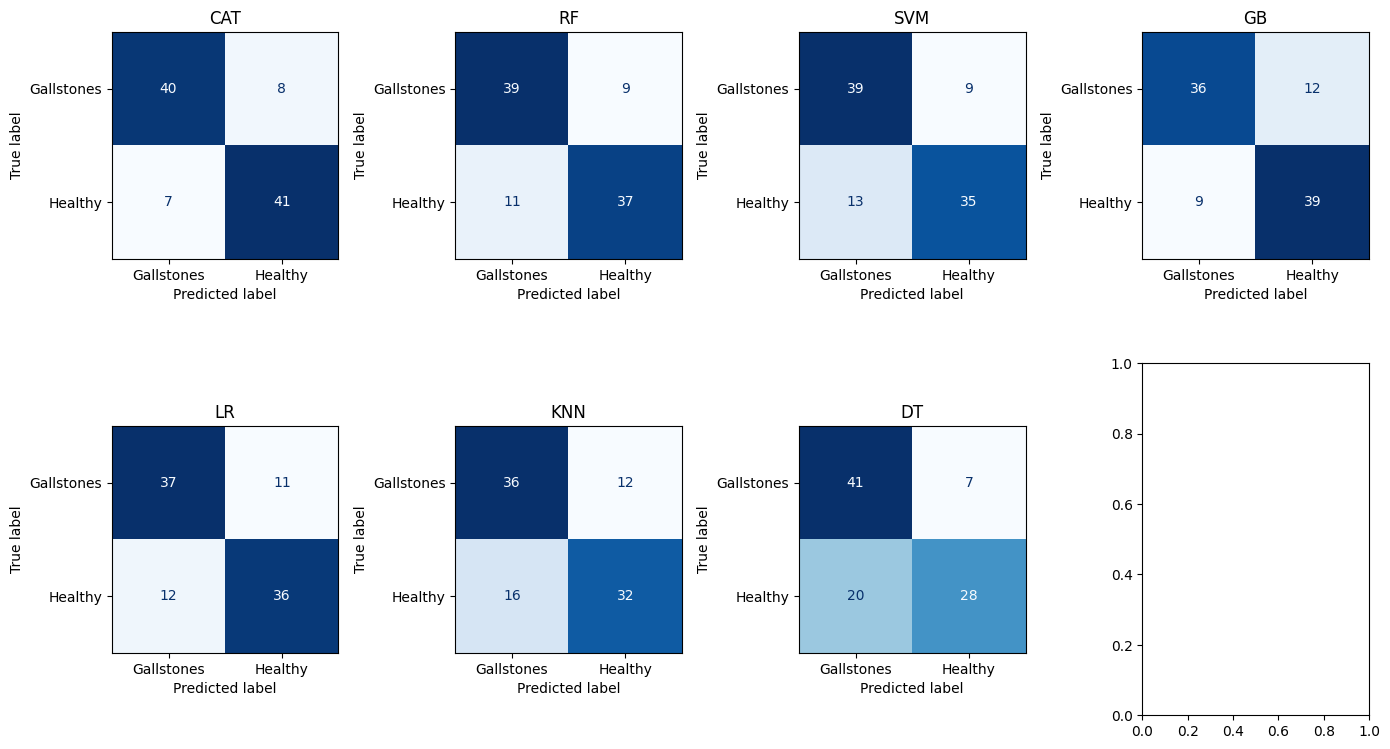

In [16]:
# --- CELDA 8: MATRICES DE CONFUSIÓN ---
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(
    nrows=2, ncols=int(np.ceil(len(results_df)/2)), 
    figsize=(14, 8)
)

axes = axes.ravel()

for idx, name in enumerate(results_df["model"]):
    clf = results_df.loc[idx, "model"]
    best_params = results_df.loc[idx, "best_params"]
    
    # reconstruir el modelo con sus mejores params
    base_clf, _ = models_and_params[name]
    model = Pipeline(steps=[
        ("scaler", scaler),
        ("select", selector),
        ("clf", base_clf.set_params(**{k.split("__")[1]: v for k,v in best_params.items()}))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Gallstones", "Healthy"])
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(f"{name}")

plt.tight_layout()
plt.show()


In [17]:
# --- CELDA 9: RESUMEN FINAL ---
summary = results_df[[
    "model", "cv_auc_mean", "test_accuracy", "test_precision", "test_recall", "test_f1", "test_auc"
]].copy()

summary.columns = [
    "Modelo", "AUC (CV)", "Accuracy", "Precisión", "Recall", "F1-score", "AUC (Test)"
]

print("Resumen de desempeño por modelo:\n")
display(summary.round(3))

best_model = summary.iloc[0]
print(f"\n🏆 Mejor modelo: {best_model['Modelo']} con AUC (Test) = {best_model['AUC (Test)']:.3f}")


Resumen de desempeño por modelo:



,Modelo,AUC (CV),Accuracy,Precisión,Recall,F1-score,AUC (Test)
0,CAT,0.852,0.844,0.837,0.854,0.845,0.907
1,RF,0.848,0.792,0.804,0.771,0.787,0.892
2,SVM,0.853,0.771,0.795,0.729,0.761,0.885
3,GB,0.840,0.781,0.765,0.812,0.788,0.885
4,LR,0.810,0.760,0.766,0.750,0.758,0.867
5,KNN,0.778,0.708,0.727,0.667,0.696,0.771
6,DT,0.735,0.719,0.800,0.583,0.675,0.757



🏆 Mejor modelo: CAT con AUC (Test) = 0.907


Tabla de importancia de variables (ANOVA F-score):


,Feature,F-Score,p-value
0,Vitamin D,45.673,0.000
1,C-Reactive Protein (CRP),27.386,0.000
2,Lean Mass (LM) (%),17.023,0.000
3,Total Body Fat Ratio (TBFR) (%),16.978,0.000
4,Bone Mass (BM),15.600,0.000
5,Hemoglobin (HGB),12.782,0.000
6,Extracellular Water (ECW),10.425,0.001
7,Total Fat Content (TFC),9.452,0.002
8,Extracellular Fluid/Total Body Water (ECF/TBW),9.414,0.002
9,Hyperlipidemia,8.533,0.004


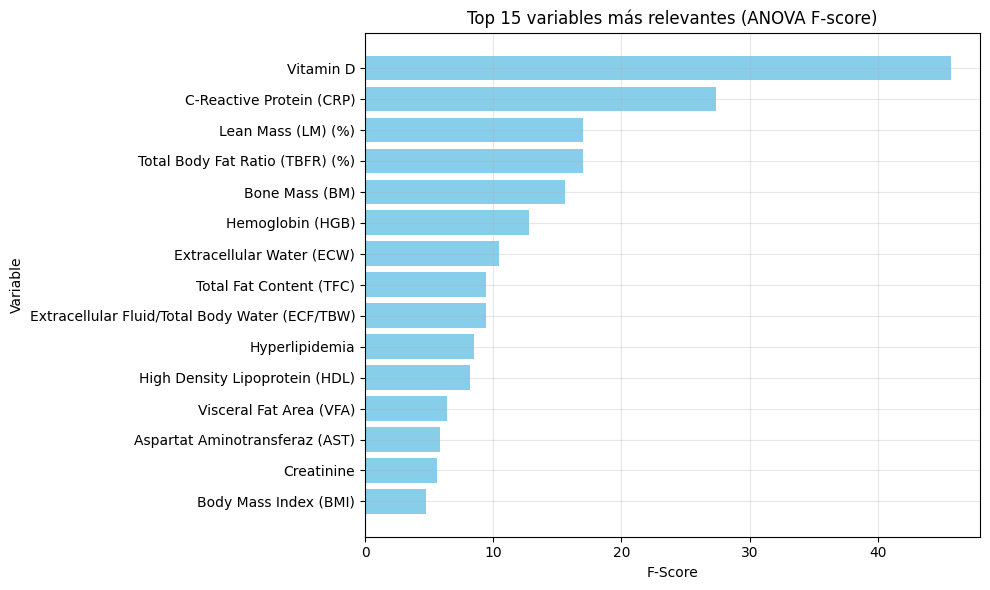

In [18]:
# --- CELDA 10: IMPORTANCIA DE VARIABLES (ANOVA F-score) ---
from sklearn.feature_selection import f_classif

# Recalculamos F-score para todo el dataset completo
f_values, p_values = f_classif(X, y)

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": f_values,
    "p-value": p_values
}).sort_values("F-Score", ascending=False).reset_index(drop=True)

print("Tabla de importancia de variables (ANOVA F-score):")
display(feature_importance.round(3))

# --- Opcional: gráfico de barras ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:15][::-1],
         feature_importance["F-Score"][:15][::-1],
         color="skyblue")
plt.title("Top 15 variables más relevantes (ANOVA F-score)")
plt.xlabel("F-Score")
plt.ylabel("Variable")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
